# pulse_input_DDM joint model (basic!) tutorial

This is a not very detailed detailed, crash course in using this code to fit the classic "Bing's model" to neural and choice data. Things you can learn:

- How to load your data
- How to plot some PSTHs, grouped by evidence strength
- How to fit the model
- How to save results

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `pulse_input_DDM` parallelizes the computation of the log-likelhood across trials.

In [1]:
using Distributed
addprocs(44);

when `using` is called after workers have been made, i.e. above, then those modules are available on all the workers (i.e. any function called from those modules will be able to be executed on any worker)

In [2]:
using pulse_input_DDM

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1278
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
│   exception = ArgumentError: Invalid checksum in cache file /usr/people/briandd/.julia/compiled/v1.5/pulse_input_DDM/m8WoA_xjkTO.ji.
└ @ Base loading.jl:1042
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
│   exception = ArgumentError: Invalid checksum in cache file /usr/people/briandd/.julia/compiled/v1.5/pulse_input_DDM/m8WoA_xjkTO.ji.
└ @ Base loading.jl:1042
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
│   exception = ArgumentError: Invalid checksum in cache file /usr/people/briandd/.julia/compiled/v1.5/pulse_input_DDM/m8WoA_xjkTO.ji.
└ @ Base loa

define a path to where the data you want to fit is located. 

See [this page](https://brody-lab.github.io/pulse_input_DDM/dev/generated/fit_choice_model/) for the expected format for `.MAT` files if one were fitting the choice model. In addition to those fields, for a neural model `rawdata` should also contain an  extra field:

- `rawdata.spike_times`: cell array containing the spike times of each neuron on an individual trial. The cell array will be length of the number of neurons recorded on that trial. Each entry of the cell array is a column vector containing the relative timing of spikes, in seconds. Zero seconds is the start of the click stimulus. Spikes before and after the click inputs should also be included.

The convention for fitting the neural model is that each session should have its own `.MAT` file. (This constrasts with the convetion for the choice model, where a single `.MAT` file can contain data from different session). It's just easier this way, especially if different sessions have different number of cells.

In [3]:
path = "/usr/people/jtb3/projects/pbups_dyn/data/brian_phys_format"

"/usr/people/jtb3/projects/pbups_dyn/data/brian_phys_format"

see what files are located in that directory. Let's use only the first one `files[1]`

In [4]:
files = readdir(path)

10-element Array{String,1}:
 "dyn_phys_H066_565672.mat"
 "dyn_phys_H066_565685.mat"
 "dyn_phys_H066_596211.mat"
 "dyn_phys_H066_597294.mat"
 "dyn_phys_H066_598129.mat"
 "dyn_phys_H066_598420.mat"
 "dyn_phys_H066_598719.mat"
 "dyn_phys_H066_599049.mat"
 "dyn_phys_H066_599345.mat"
 "dyn_phys_H066_600163.mat"

## Load your real data

to load youre data you are going to use the `load_neural_data` function, which is a bit complicated. To access its `docstring` (or any `docstring` in julia for that matter) type `? [name_of_function]`

In Julia, multiple functions can have the same name (called multiple dispatch). Julia's compiler decides which function to use depending on the inputs. Every function with that name you query will be listed below.

In [5]:
? load_neural_data

search: load_neural_data reload_neural_data reload_neural_model



```
load_neural_data(file::Vector{String}; centered, dt, delay, pad, filtSD, extra_pad, cut, pcut)
```

Calls `load_neural_data` for each entry in `file` and then creates three array outputs—`spike_data`, `μ_rnt`, `μ_t`—where each entry of an array is the relevant data for a single session. 

Returns:

  * `data`: an `array` of length number of session. Each entry is for a session, and is another `array`. Each entry of the sub-array is the relevant data for a trial.
  * `μ_rnt`: an `array` of length number of sessions. Each entry is another `array` of length number of trials. Each entry of the sub-array is also an `array`, of length number of cells. Each entry of that array is the filtered single-trial firing rate of each neuron
  * `μ_t`: an `array` of length number of sessions. Each entry is an `array` of length number of cells. Each entry is the trial-averaged firing rate (across all trials).

---

```
load_neural_data(file::String; centered, dt, delay, pad, filtSD, extra_pad, cut, pcut)
```

Load neural data `.MAT` file and return an three `arrays`. The first `array` is the `data` formatted correctly for fitting the model. Each element of `data` is a module-defined class called `neuraldata`.

The package expects your data to live in a single `.MAT` file which should contain a struct called `rawdata`. Each element of `rawdata` should have data for one behavioral trial and `rawdata` should contain the following fields with the specified structure:

  * `rawdata.leftbups`: row-vector containing the relative timing, in seconds, of left clicks on an individual trial. 0 seconds is the start of the click stimulus
  * `rawdata.rightbups`: row-vector containing the relative timing in seconds (origin at 0 sec) of right clicks on an individual trial. 0 seconds is the start of the click stimulus.
  * `rawdata.T`: the duration of the trial, in seconds. The beginning of a trial is defined as the start of the click stimulus. The end of a trial is defined based on the behavioral event “cpoke_end”. This was the Hanks convention.
  * `rawdata.pokedR`: Bool representing the animal choice (1 = right).
  * `rawdata.spike_times`: cell array containing the spike times of each neuron on an individual trial. The cell array will be length of the number of neurons recorded on that trial. Each entry of the cell array is a column vector containing the relative timing of spikes, in seconds. Zero seconds is the start of the click stimulus. Spikes before and after the click inputs should also be included.

Arguments:

  * `file`: path to the file you want to load.

Optional arguments;

  * `break_sim_data`: this will break up simulatenously recorded neurons, as if they were recorded independently. Not often used by most users.
  * `centered`: Defaults to true. For the neural model, this aligns the center of the binned spikes, to the beginning of the binned clicks. This was done to fix a numerical problem. Most users will never need to adjust this.
  * `dt`: Binning of the spikes, in seconds.
  * `delay`: How much to offset the spikes, relative to the accumlator, in units of `dt`.
  * `pad`: How much extra time should spikes be considered before and after the begining of the clicks. Useful especially if delay is large.
  * `filtSD`: standard deviation of a Gaussin (in units of `dt`) to filter the spikes with to generate single trial firing rates (`μ_rnt`), and mean firing rate across all trials (`μ_t`).
  * `extra_pad`: Extra padding (in addition to `pad`) to add, for filtering purposes. In units of `dt`.
  * `cut`: How much extra to cut off at the beginning and end of filtered things (should be equal to `extra_pad` in most cases).
  * `pcut`: p-value for selecting cells.

Returns:

  * `data`: an `array` of length number of trials. Each element is a module-defined class called `neuraldata`.
  * `μ_rnt`: an `array` of length number of trials. Each entry of the sub-array is also an `array`, of length number of cells. Each entry of that array is the filtered single-trial firing rate of each neuron.
  * `μ_t`: an `array` of length number of cells. Each entry is the trial-averaged firing rate (across all trials).


In [6]:
pcut, delay, pad, dt = Inf, 6, 20, 1e-2

(Inf, 6, 20, 0.01)

depending on how many cells you are loading, `load_neural_data` can take some time

In [7]:
data, μ_rnt, μ_t = load_neural_data(joinpath.(path, files), pcut=pcut, pad=pad, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

In [8]:
μ_t = vcat(μ_t...);

the contents of `data` for the first (and only) session, first trial will be a module-defined type `neuraldata`

In [9]:
data[1][1]

neuraldata
  input_data: pulse_input_DDM.neuralinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}
  spikes: Array{Array{Int64,1}}((9,))
  ncells: Int64 9
  choice: Bool true


In [10]:
? neuraldata

search: neuraldata load_neural_data reload_neural_data neuralDDM neural_poly_DDM



```
neuraldata
```

Module-defined class for keeping data organized for the `neuralDDM` model.

Fields:

  * `input_data`: stuff related to the input of the accumaltor model, i.e. clicks, etc.
  * `spikes`: the binned spikes
  * `ncells`: numbers of cells on that trial (should be the same for every trial in a session)
  * `choice`: choice on that trial

---



In [11]:
ncells = map(x-> x[1].ncells, data)

10-element Array{Int64,1}:
 9
 3
 1
 2
 2
 2
 1
 2
 1
 1

## Plot your data

Here's some pretty basic Julia code for taking a look at the cells you're about to analyze. My most simple type of plot is to group trials into `nconds` number of groups based on the total amount of evidence, and plot the average firing rate as a function of time for those two groups.

In [12]:
nconds = 2

2

In [13]:
? process_spike_data

search: process_spike_data



```
process_spike_data(μ_rnt, data)
```

Arguments:

  * `μ_rnt`: `array` of Gaussian-filterd single trial firing rates for all cells and all trials in one session. `μ_rnt` is output from `load_neural_data`.
  * `data`: `array` of all trial data for one session. `data` is output from `load_neural_data`.

Optional arguments: 

  * `nconds`: number of groups to make to compute PSTHs

Returns: 

  * `μ_ct`: mean PSTH for each group.
  * `σ_ct`: 1 std PSTH for each group.


In [14]:
output = process_spike_data.(μ_rnt, data; nconds=nconds);

In [15]:
μ_ct, σ_ct = getindex.(output, 1), getindex.(output, 2);
μ_ct, σ_ct = vcat(μ_ct...), vcat(σ_ct...);

In [16]:
using PyPlot, Colors
my_colors= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=nconds)));

Finally, plot the PSTHs for each cell. Julia basially uses pythons `PyPlot` and the syntax is too cumbersome to explain here. So if this next cell doesn't make any sense, don't worry, becuase it's tricky.

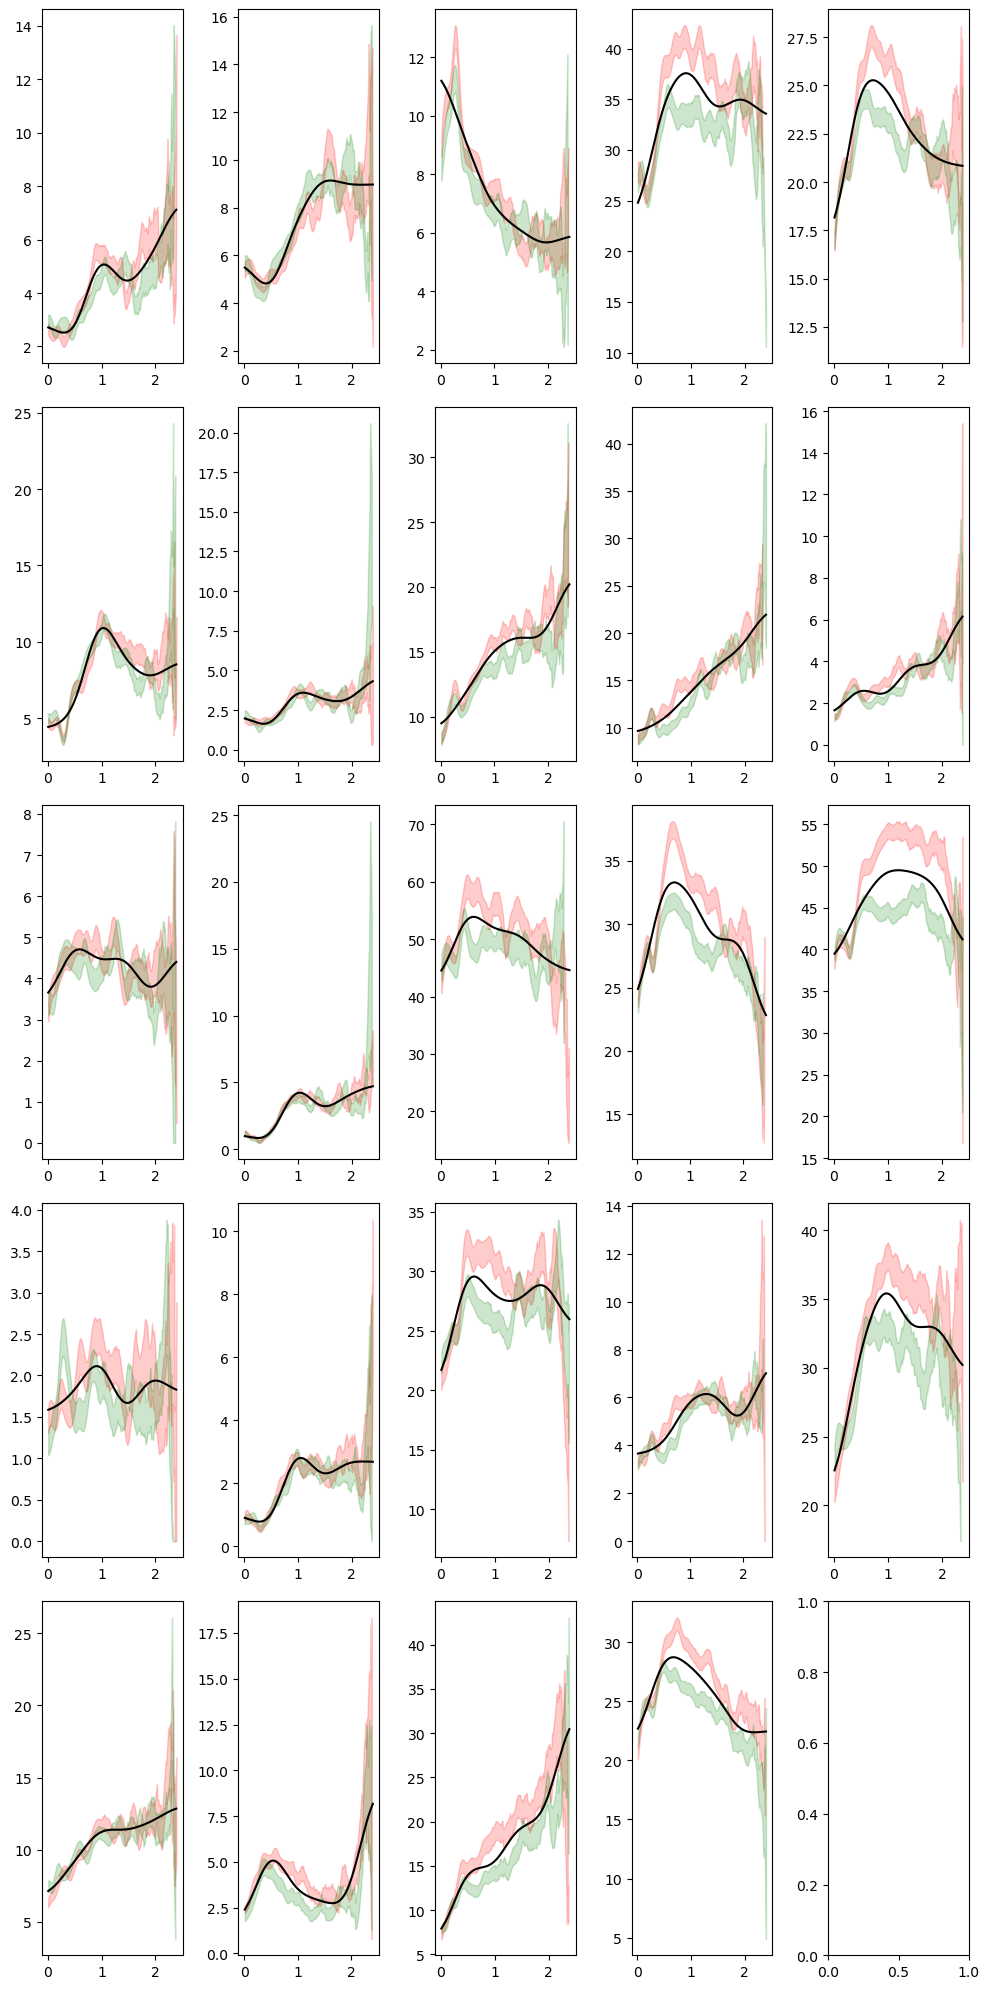

In [17]:
num_rows, num_cols = 5,5
fig, ax = subplots(num_rows, num_cols, figsize=(10,20))

for j in 1:length(μ_ct)  

    for k = 1:nconds   

        ax[j].fill_between((1:length(μ_ct[j][k]))*dt,
            μ_ct[j][k] + σ_ct[j][k],
            μ_ct[j][k] - σ_ct[j][k],
            alpha=0.2, color=my_colors[k]) 

    end   

    ax[j].plot((1:length(μ_t[j]))*dt,
       μ_t[j], color="black")            

end

tight_layout() 

## Fit the model

for the neural model, we need to decide the functional form of the non-linear function between the accumlator and the spikes.

`f`: the tuning curve between a(t) and the expected firing rate. There are two options here, `Sigmoid` and `Softplus`. `Softplus` is simpler, and thus faster to fit, with less concern of overfitting.

It's possibe to assign different forms to differnet neurons. As such `f` should be an `array`, with one element for each session. Each element is another `array`, each elemnt of which is a `string` for the tuning curve choice for each neuron.

In [18]:
f = all_Softplus(data)

10-element Array{Array{String,1},1}:
 ["Softplus", "Softplus", "Softplus", "Softplus", "Softplus", "Softplus", "Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus", "Softplus"]
 ["Softplus"]
 ["Softplus", "Softplus"]
 ["Softplus", "Softplus"]
 ["Softplus", "Softplus"]
 ["Softplus"]
 ["Softplus", "Softplus"]
 ["Softplus"]
 ["Softplus"]

In [19]:
? Softplus

search: Softplus all_Softplus



Softplus(c)

$\lambda(a) = \ln(1 + \exp(c * a))$


In [20]:
? optimize

search: optimize choice_optimize choice_neural_optimize



```
optimize(x, ll, lb, ub)
```

Wrapper for executing an constrained optimization.

Arguments:

  * `ll`: objective function.
  * `x`: an `array` of initial point
  * `lb`: lower bounds. `array` the same length as `x`.
  * `ub: upper bounds.`array`the same length as`x`.

---

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(data, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `data`: an `array`, each element of which is a module-defined type `choicedata`. `choicedata` contains the click data and the choice for a trial.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM_dx`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM_dx`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(data, f)
```

Optimize model parameters for a `neuralDDM`. Neural tuning parameters ([`θy`](@ref)) are initialized by fitting a the noiseless DDM model first ([`noiseless_neuralDDM`](@ref)).

Arguments:

  * `data`: the output of [`load_neural_data`](@ref) with the format as described in its docstring.
  * `f`: an `array` of length number of sessions, where each subarray is length number of cells. Each entry is a string, either `Softplus` or `Sigmoid` to describe the nonlinear map between $a(t)$ and $\lambda(a)$, the expected firing rate.

Returns

  * `model`: a module-defined type that organizes the `data` and parameters from the fit (as well as a few other things that are necessary for re-computing things the way they were computed here (e.g. `n`)
  * `options`: some details related to the optimzation, such as which parameters were fit, and the upper and lower bounds of those parameters.

---

```
optimize(model, options)
```

Optimize model parameters for a `neuralDDM`.

Arguments: 

  * `model`: an instance of a `neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `noiseless_neuralDDM`.

Arguments: 

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM`.

Arguments: 

  * `model`: an instance of a `HMMDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `neural_choice_GLM_DDM`.

Arguments: 

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_joint`.

Arguments: 

  * `model`: an instance of a `HMMDDM_joint`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_joint`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_joint_2`.

Arguments: 

  * `model`: an instance of a `HMMDDM_joint_2`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_joint_2`.
  * `output`: results from [`Optim.optimize`](@ref).


Just running this for 1 optimizaion iteration to illustrate how this works

In [ ]:
model, options = choice_neural_optimize(data, show_trace=true, f_tol=1e-12, iterations=1, outer_iterations=1)

Fminbox
-------
Initial mu = 0.152202

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.152202

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     8.408292e+05     5.059159e+04
 * time: 0.012181997299194336


call a different version of optimize, just to show how to keep optimizing a model if it's already been fit

In [22]:
model, = choice_neural_optimize(model, options, iterations=1, outer_iterations=1)

Fminbox
-------
Initial mu = 0.0162523

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0162523

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     8.394099e+05     6.868303e+02
 * time: 0.002480030059814453

Exiting inner optimizer with x = [0.10197936146758915, 15.00134151269549, -0.06417406434723358, 20.00029816830107, 0.8052326755227484, 0.10326803285746072, 0.679120888699662, -0.005302535372806071, 0.12595182391625692, -0.13498627382591208, -0.12349831410818782, -0.07886075510452131, -0.1385474672911704, -0.0933290316975438, 0.04410631371177825, -0.12429374316033238, -0.15017986187113902, -0.12438484332715397, -0.36655502186935535, -0.07303358991771172, -0.12096819769865662, -0.09988372705008233, -0.11187928632463953, -0.15215193432486035, -0.15388773447127033, -0.06737953745102584, -0.1937451574527912, -0.07316669339348415, -0.1473794410557294, -0.1341672209748346, -0.18793064545286517, -0.27351466049910794

(neural_choiceDDM{θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((10,))
  n: Int64 53
  cross: Bool false
,  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.02e-01, 1.50e+01, -6.42e-02,  ...]
    Minimum:   8.385151e+05

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.00e-01, 1.50e+01, -1.07e-01,  ...]

 * Convergence measures
    |x - x'|               = 5.89e-01 ≰ 1.0e-10
    |x - x'|/|x'|          = 2.35e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.97e+02 ≰ 1.0e-09
    |f(x) - f(x')|/|f(x')| = 1.07e-03 ≰ 0.0e+00
    |g(x)|                 = 6.38e+02 ≰ 1.0e-03

 * Work counters
    Seconds run:   196  (vs limit 170000)
    Iterations:    1
    f(x) calls:    13
    ∇f(x) calls:   2
)

In [23]:
? simulate_expected_firing_rate

search: simulate_expected_firing_rate



```
simulate_expected_firing_rate(model)
```

Given a `model` generate samples of the firing rate `λ` of each neuron.

Arguments:

  * `model`: an instance of a `neuralDDM`.

Optional arguments:

  * `num_samples`: How many independent samples of the latent to simulate, to average over.

Returns:

  * `λ`: an `array` is length `num_samples`. Each entry an `array` of length number of trials. Each entry of that is an `array` of length number of neurons. Each entry of that is the firing rate of that neuron on that trial for some length of time.
  * `μ_λ`: the mean firing rate for each neuron (averaging across the noise of the latent process for `num_samples` trials).
  * `μ_c_λ`: the average across trials and across group with similar evidence values (grouped into `nconds` number of groups).


In [24]:
μ_λ, μ_c_λ, = simulate_expected_firing_rate(model; num_samples=100, nconds=nconds); 

In [25]:
μ_c_λ = vcat(μ_c_λ...);

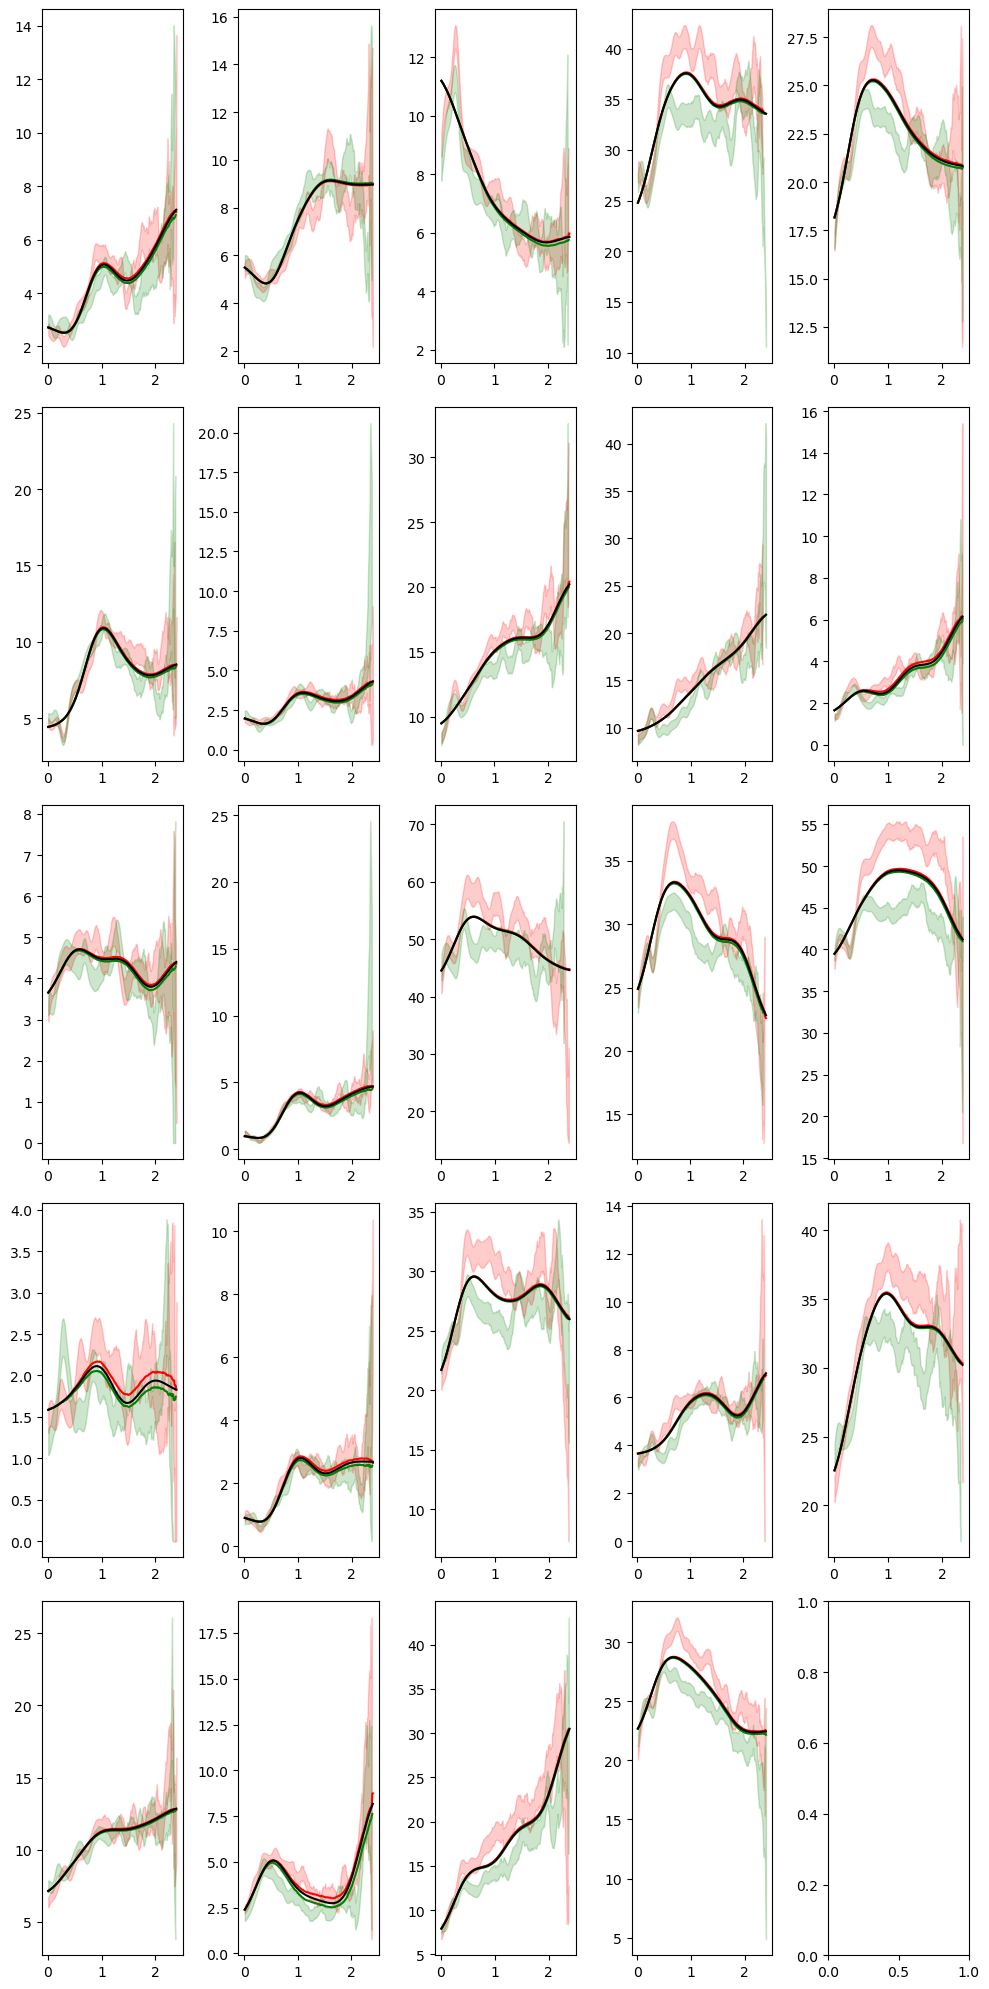

In [26]:
fig, ax = subplots(num_rows, num_cols, figsize=(10,20))

for j in 1:length(μ_ct)  

    for k = 1:nconds   

        ax[j].fill_between((1:length(μ_ct[j][k]))*dt,
            μ_ct[j][k] + σ_ct[j][k],
            μ_ct[j][k] - σ_ct[j][k],
            alpha=0.2, color=my_colors[k]) 
        
        ax[j].plot((1:length(μ_c_λ[j][k]))*dt,
            μ_c_λ[j][k], color=my_colors[k])  

    end   

    ax[j].plot((1:length(μ_t[j]))*dt,
       μ_t[j], color="black")            

end

tight_layout() 

## Save your results

This section, and the one below, will walk you through the basics of saving the output of the model fitting procedure, so you can reload it later.

In [27]:
save_path = ENV["HOME"]
!isdir(save_path) ? mkdir(save_path) : nothing   
file = joinpath(save_path, "brian_test.mat");

In [28]:
? save_neural_model

search: save_neural_model



```
save_neural_model(file, model, options)
```

Given a `file`, `model` and `options` produced by `optimize`, save everything to a `.MAT` file in such a way that `reload_neural_data` can bring these things back into a Julia workspace, or they can be loaded in MATLAB.

See also: [`reload_neural_model`](@ref)


In [29]:
save_neural_model(file, model, options)

In [30]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 0.10197936146758915
  B: Float64 15.00134151269549
  λ: Float64 -0.06417406434723358
  σ2_a: Float64 20.00029816830107
  σ2_s: Float64 0.8052326755227484
  ϕ: Float64 0.10326803285746072
  τ_ϕ: Float64 0.679120888699662


## Reloading some saved stuff

In [31]:
? reload_neural_choice

search: reload_neural_model reload_neural_data

Couldn't find reload_neural_choice
Perhaps you meant reload_neural_model


No documentation found.

Binding `reload_neural_choice` does not exist.


In [36]:
θ, options, n, cross = reload_joint_model(file)

(θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  θz: θz{Float64}
  bias: Float64 -0.005302535372806071
  lapse: Float64 0.12595182391625692
  θy: Array{Array{Softplus{Float64},1}}((10,))
  f: Array{Array{String,1}}((10,))
, neural_choice_options
  fit: Array{Bool}((33,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ub: Array{Float64}((33,)) [100.0, 40.0, 5.0, 400.0, 10.0, 1.2, 1.0, 10.0, 1.0, 10.0  …  10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
  lb: Array{Float64}((33,)) [0.001, 8.0, -5.0, 0.001, 0.001, 0.001, 0.005, -10.0, 0.0, -10.0  …  -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]
, 53, false, 0.01, 6, 20)

Reconstruct the `neuralDDM` model with the outputs of `reload_neural_model`

In [37]:
model = neural_choiceDDM(θ, data, n, cross)

neural_choiceDDM{θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural_choice{θz{Float64},Float64,Array{Array{Softplus{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((10,))
  n: Int64 53
  cross: Bool false


## Computing the gradient and the hessian at the maximum likelihood solution

In [38]:
? gradient

search: gradient



```
gradient(model)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `choiceDDM`.

---

```
gradient(model)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `neuralDDM` or a `noiseless_neuralDDM`.

---

```
gradient(model)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `HMMDDM`.

---

```
gradient(model; remap)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `neural_choiceDDM`.

Arguments:

  * `model`: instance of `neural_choiceDDM`

Optional arguments:

  * `remap`: For considering parameters in variance of std space.

---

```
gradient(model)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `HMMDDM_joint`.

---

```
gradient(model)
```

Compute the gradient of the negative log-likelihood at the current value of the parameters of a `HMMDDM_joint_2`.


In [39]:
g = gradient(model)

33-element Array{Float64,1}:
  -54.559344341787515
  -10.00024361747471
 -273.95173565289076
   -9.793360187745266
  -18.332463188105088
 -345.3745082983995
  380.0345128773628
    4.949038561328085
   69.29543192609978
  448.64424452060223
  236.09461387659314
   73.21859099782839
  119.34281909007754
    ⋮
   23.358566132971628
   89.6606143789011
  186.1395361165818
   91.8109908092656
   74.0854876512197
  273.092723792865
   61.72924114235496
  179.52011203405795
  199.5655387711352
   86.00299332595887
  279.982765627621
   93.95894792025949

In [42]:
using LinearAlgebra: norm, eigvals
norm(g)

1382.0222505255733

In [43]:
? Hessian

search: Hessian



```
Hessian(model)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `choiceDDM`.

---

```
Hessian(model; chunck_size, remap)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `neuralDDM` or a `noiseless_neuralDDM`.

Arguments:

  * `model`: instance of `neuralDDM` or `noiseless_neuralDDM`

Optional arguments:

  * `chunk_size`: parameter to manange how many passes over the LL are required to compute the Hessian. Can be larger if you have access to more memory.
  * `remap`: For considering parameters in variance of std space.

---

```
Hessian(model; chunck_size)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `HMMDDM`.

Arguments:

  * `model`: instance of `HMMDDM`

Optional arguments:

  * `chunk_size`: parameter to manange how many passes over the LL are required to compute the Hessian. Can be larger if you have access to more memory.

---

```
Hessian(model; chunck_size, remap)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `neural_choiceDDM`.

Arguments:

  * `model`: instance of `neural_choiceDDM`

Optional arguments:

  * `chunk_size`: parameter to manange how many passes over the LL are required to compute the Hessian. Can be larger if you have access to more memory.
  * `remap`: For considering parameters in variance of std space.

---

```
Hessian(model; chunck_size)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `HMMDDM_joint`.

Arguments:

  * `model`: instance of `HMMDDM_joint`

Optional arguments:

  * `chunk_size`: parameter to manange how many passes over the LL are required to compute the Hessian. Can be larger if you have access to more memory.

---

```
Hessian(model; chunck_size)
```

Compute the hessian of the negative log-likelihood at the current value of the parameters of a `HMMDDM_joint_2`.

Arguments:

  * `model`: instance of `HMMDDM_joint_2`

Optional arguments:

  * `chunk_size`: parameter to manange how many passes over the LL are required to compute the Hessian. Can be larger if you have access to more memory.


In [44]:
H = Hessian(model)

33×33 Array{Float64,2}:
 288.622     -3.31748     -10.6712   …    -3.2556      9.51837    3.15954
  -3.31748    2.07151      -7.6702        -5.287       4.24979    1.13101
 -10.6712    -7.6702      214.111       -316.055     157.562     54.0162
   0.861444  -0.60028       4.16179       -6.64291     5.00115    1.40521
   1.59633   -1.10695      11.1112       -16.1077     10.0239     2.9562
   4.5272     1.50298      71.3539   …   -30.3523     50.3787    15.4567
  -5.5798    -0.842988    -84.3002        42.0624    -59.0832   -17.8984
  -0.190511   0.0291303    -3.3102        -6.30804    -1.63285    0.13706
 -18.0135    -6.04034    -376.46         428.257      -7.45536  -56.0685
  33.8991     6.27842      10.6682        -0.0        -0.0       -0.0
   7.18665    3.06998     -19.4983   …    -0.0        -0.0       -0.0
   5.38977   -0.649249    -98.1623        -0.0        -0.0       -0.0
  13.1946    -4.53578    -237.687         -0.0        -0.0       -0.0
   ⋮                               

eigenvalues are all positive, meaning H is positive semidefinite

In [45]:
eigvals(H)

33-element Array{Float64,1}:
 -1084.1505762753177
  -441.82515432160307
  -267.274869386982
  -157.16540625129164
   -35.27400770423938
     0.27860384997026716
     1.5493952637291928
     4.768245049587126
    16.544465758897612
    28.044632251771286
    51.46006184984558
    84.15639702078391
   145.37697815611423
     ⋮
  1001.3558963664456
  1334.262379321672
  1787.6303478422203
  1875.1663601417781
  1922.0534086664018
  2321.1712714214214
  2594.2332945769253
  2876.0550858796755
  3183.7919552675094
  3810.163796773313
  3918.2901919164055
  4376.215657340923

compute confidence intervals using LaPlace approximation

In [46]:
using LinearAlgebra: diag
CI = hcat(flatten(model.θ) - 2*sqrt.(diag(inv(H))), flatten(model.θ), flatten(model.θ) + 2*sqrt.(diag(inv(H))))

LoadError: DomainError with -0.0016701075932721106:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).